# SIMULATION PROBLEM 
Generate data for x number of requests, including their arrival times and service times. 
We will determine the number of requests.
Inter-arrival times following an exponential distribution will be generated, thus providing arrival times following a Poisson distribution.
Request size be randomly generated following a normal distribution, and this is used to calculate service times.
After obtaining the data, we will simulate multiple scenarios of queues with different numbers of servers. 
For the different number of servers, we will be comparing two different queueing disciplines: FCFS and SJF.

# OUTPUTS 
For all different scenarios of servers, calculate average waiting time (sec) and server utilization of both types of queueing disciplines.
Calculate Confidence and Prediction Intervals for all scenarios regarding the differences in performance of the two types of queueing disciplines.
Compare which queueing discipline is better: the one that minimizes wait times and maximizes efficiency.

## SECTION 0: Import

In [14]:
import numpy as np 
import random 
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl import load_workbook
import seaborn as sns
from scipy import stats

## SECTION 1: Variable and Preparation

#TODO Write an experiment plan

In [15]:
# DECLARE VARIABLES 

# mount time [sec]
M = 15 # from the paper, fixed 

# unmount time [sec]
U = 77 # from the paper, fixed 

# seek time [sec]
s = 60 # from the paper, fixed 

# number of requests 
R = 0 # determined by the modellers 

# request size [MB]
Q = 0 # will be randomly generated from normal distribution using given parameters 

# request size mean [MB]
Qbar = 843 # from the paper, 843 MB

# request size standard deviation [MB]
std_dev = 2800 # from the paper, 2.8 GB 

# request size variance [MB**2]
Q2 = 8500 # from the paper, 8.5 GB

# transfer bandwidth [MB/sec]
bw = 360 # from the paper, assumed 

# arrival rate [requests per second]
arrival_rate = 0.005 # lambda not given in paper, determined by modellers 

# arrival times
arrival_time = 0 # follows Poisson distribution, will be calculated from generated inter-arrival times 

# inter-arrival times 
IAT = 0 # randomly generated following exponential distribution, used to calculate arrival times 

# inter-arrival time mean
IAT_mean = 1/arrival_rate

# previous arrival
previous_arrival = 0 # the time of previous request's arrival 

# wait time 
wait_time = 0 # the wait time of requests 

# delta 
delta = 0 # used in calculating wait times 

# previous departure 
previous_departure = 0 # the time of the previous request's departure 


In [16]:
# STATIC PARAMETERS

# Always-Unmount Policy: 
# a tape cartridge is immediately unmounted upon completion of all pending requests for it
# in anticipation of the next request arriving for another non-mounted cartridge 

# Light-Load Scenario: 
# lambda (arrival rate) is relatively small 
# there is at most one request pending in each queue 
# all outstanding requests form a virtual queue that is served by the d tape drives 

# The number of tape cartridges and tape drives will remain the same 

In [17]:
# KEY FORMULAS 

# time to serve a request 
B = s + (Q/bw)

# total service time for cartridge 
service_time = M + B + U 

In [18]:
# OUTPUT FORMULAS 

# Waiting Times:
# max(0, delta)
# where delta = min(earliest of the recent departures) - current arrival

# Average Waiting Time:
# sum of wait times in specified time interval - number of requests in specified time interval 

# Server Utilization:
# rho = lambda * Bbar / d 
# where lambda is arrival rate, Bbar is the mean request service time, Bbar = sbar + Qbar/bw, and d is number of tape drives 
# where sbar is mean seek time (fixed at 60 sec), Qbar is mean request size (843 MB), and bw is transfer bandwidth (360 MB/sec)

In [19]:
# FUNCTION TO GENERATE INTER-ARRIVAL TIMES
# for arrival times to follow a Poisson process, the inter-arrival times are exponentially distributed and the mean equals the inverse of the rate
# for example, if we set the arrival rate, lambda, to 3 requests per second
# then we will simulate inter-arrival times according to the exponential curve and the mean is 1/3 

IAT_mean = 1/arrival_rate

def generate_interarrival_times(IAT_mean, size):
    IAT = np.random.exponential(IAT_mean, size)
    IAT = np.clip(IAT, a_min=0, a_max=None)
    return IAT

In [20]:
# FUNCTION TO GENERATE REQUEST SIZE
def generate_request_size(mean, std_dev, size):
    Q = np.random.normal(loc=mean, scale=std_dev, size=size)
    Q = np.clip(Q, a_min=0, a_max=None)
    return Q 

In [21]:
# FUNCTION TO GENERATE SERVICE TIME
def generate_service_time(Q, s, bw, U):
    B = s + (Q/bw)
    service_time_list = M + B + U
    return service_time_list

In [22]:
# SORTING FUNCTION FOR SJF
def sort_service(e):
    return e[1][2]

In [23]:
# FCFS
def simulate_FCFS(request_list, d):
    in_system_departure_time = []
    waiting_times = []
    R = 0
    while R < number_request:
        R += 1
    
        # generate inter-arrival times first, because they will be used to calculate arrival times 
        if R == 1:
            IAT = 0 # the first request will have no inter-arrival time 
        else: 
            IAT = request_list[R - 1][0]
        
        # calculate arrival times
        if R == 1:
            arrival_time = 0 # request 1 arrival time is 0, start of the simulation time 
        else:
            arrival_time = previous_arrival + IAT
        
        previous_arrival = arrival_time # over-riding the previous arrival with the current arrival time for next request calculations 
    
        # calculate wait times according to FCFS queue discipline
        if 1 <= R <= d:
            waiting_time = 0 # these requests have 0 wait time because there are d servers available at the start (d idle servers) 
        else:
            waiting_time = max(0, min(in_system_departure_time) - arrival_time)
            in_system_departure_time.remove(min(in_system_departure_time))
        
        service_time = request_list[R - 1][2]
        system_time = waiting_time + service_time
        departure_time = arrival_time + system_time
        in_system_departure_time.append(departure_time)
        waiting_times.append(waiting_time)
    # wait time and server utilisation 
    return waiting_times, np.sum([req[2] for req in request_list]) / (d * max(in_system_departure_time))


In [24]:
# SJF
def simulate_SJF(request_list, d):
    in_system_departure_time = []
    arrival_time_list = []
    waiting_times = []
    current_time = 0
    for req in request_list:
        if arrival_time_list:
            current_time = current_time + req[0]
        arrival_time_list.append(current_time)
    R = 0
    sjf_temp_list = list(zip(arrival_time_list, request_list))
    while R < number_request:
        R += 1
        arrival_time = sjf_temp_list[0][0]
    
        # calculate wait times according to SJF queue discipline
        if 1 <= R <= d:
            waiting_time = 0 # these requests have 0 wait time because there are d servers available at the start (d idle servers) 
        else:
            waiting_time = max(0, min(in_system_departure_time) - arrival_time)
            in_system_departure_time.remove(min(in_system_departure_time))
    
        system_time = waiting_time + sjf_temp_list[0][1][2]
        departure_time = arrival_time + system_time
        in_system_departure_time.append(departure_time)
        waiting_times.append(waiting_time)
    
        # requeuing while waiting for current request
        if R > d:
            sjf_temp_list = sjf_temp_list[1:]
            cut = len(sjf_temp_list)
            for request in range(len(sjf_temp_list)):
                if sjf_temp_list[request][0] > departure_time:
                    cut = request
                    break
            with_in_departure_time_request_list = sjf_temp_list[:cut]
            with_in_departure_time_request_list = sorted(with_in_departure_time_request_list, key=sort_service)
            sjf_temp_list = with_in_departure_time_request_list + sjf_temp_list[cut:]
    # wait time and server utilisation 
    return waiting_times, np.sum([req[2] for req in request_list]) / (d * max(in_system_departure_time))

## Section 2: Preliminary Simulation

In [25]:
# SIMULATION
number_request = 100

inter_arrival_time_list = generate_interarrival_times(IAT_mean, number_request)
request_size_list = generate_request_size(Qbar, std_dev, number_request)
service_time_list = generate_service_time(request_size_list, s, bw, U)
request_list = list(zip(inter_arrival_time_list, request_size_list, service_time_list))
FCFS_2_entry, FCFS_2_system_util = simulate_FCFS(request_list, 2)
SJF_2_entry, SJF_2_system_util = simulate_SJF(request_list, 2)

FCFS_5_entry, FCFS_5_system_util = simulate_FCFS(request_list, 5)
SJF_5_entry, SJF_5_system_util = simulate_SJF(request_list, 5)

FCFS_10_entry, FCFS_5_system_util = simulate_FCFS(request_list, 10)
SJF_10_entry, SJF_5_system_util = simulate_SJF(request_list, 10)

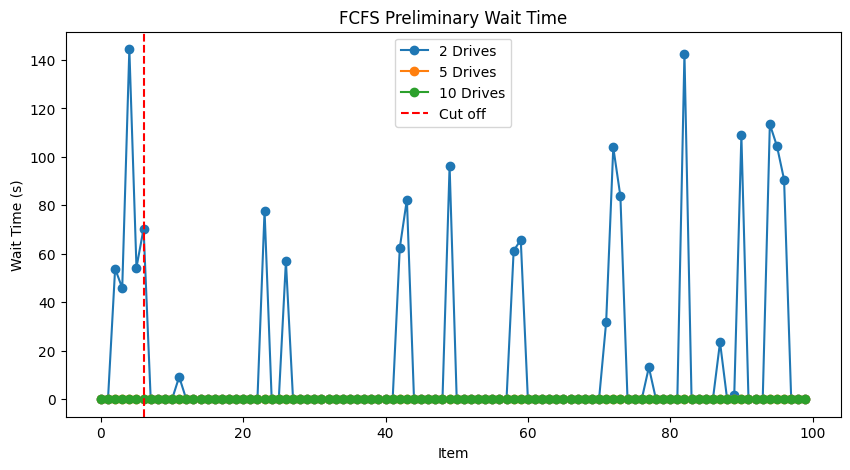

In [26]:
x_values = list(range(len(FCFS_2_entry)))

plt.figure(figsize=(10, 5)) 
plt.plot(x_values, FCFS_2_entry, label='2 Drives', marker='o')
plt.plot(x_values, FCFS_5_entry, label='5 Drives', marker='o')
plt.plot(x_values, FCFS_10_entry, label='10 Drives', marker='o')

x_coordinate = 6
plt.axvline(x=x_coordinate, color='r', linestyle='--', label=f'Cut off')

plt.xlabel('Item')
plt.ylabel('Wait Time (s)')
plt.title('FCFS Preliminary Wait Time')
plt.legend()
plt.show()

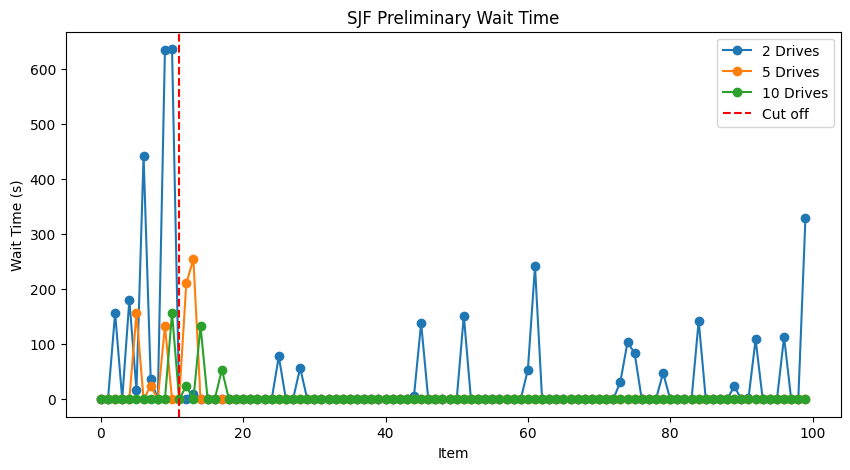

In [ ]:
x_values = list(range(len(SJF_2_entry)))

plt.figure(figsize=(10, 5)) 
plt.plot(x_values, SJF_2_entry, label='2 Drives', marker='o')
plt.plot(x_values, SJF_5_entry, label='5 Drives', marker='o')
plt.plot(x_values, SJF_10_entry, label='10 Drives', marker='o')

x_coordinate = 11
plt.axvline(x=x_coordinate, color='r', linestyle='--', label=f'Cut off')

plt.xlabel('Item')
plt.ylabel('Wait Time (s)')
plt.title('SJF Preliminary Wait Time')
plt.legend()
plt.show()

In [17]:
cut_off = 5

## Section 3: Real Simulation

In [31]:
def save_sim(d, cut_off, file_path):
    header = ['Avg_Wait_Time', 'System_Util']
    FCFS_data = []
    SJF_data = []
    for i in range(30):
        number_request = 1000
        
        inter_arrival_time_list = generate_interarrival_times(IAT_mean, number_request)
        request_size_list = generate_request_size(Qbar, std_dev, number_request)
        service_time_list = generate_service_time(request_size_list, s, bw, U)
        request_list = list(zip(inter_arrival_time_list, request_size_list, service_time_list))
        FCFS_entry, FCFS_system_util = simulate_FCFS(request_list, d)
        FCFS_entry = FCFS_entry[cut_off:]
        FCFS_data.append([np.mean(FCFS_entry), FCFS_system_util])
        SJF_entry, SJF_system_util = simulate_SJF(request_list, d)
        SJF_entry = FCFS_entry[cut_off:]
        SJF_data.append([np.mean(SJF_entry), SJF_system_util])
    try:
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
            pd.DataFrame(FCFS_data).to_excel(writer, sheet_name='FCFS' + str(d), startrow=0, index=False, header=header)
            pd.DataFrame(SJF_data).to_excel(writer, sheet_name='SJF' + str(d), startrow=0, index=False, header=header)
    except FileNotFoundError:
        with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
            writer.book.create_sheet('FCFS' + str(d))
            writer.book.create_sheet('SJF' + str(d))
            pd.DataFrame(FCFS_data).to_excel(writer, sheet_name='FCFS' + str(d), startrow=0, index=False, header=header)
            pd.DataFrame(SJF_data).to_excel(writer, sheet_name='SJF' + str(d), startrow=0, index=False, header=header)

In [ ]:
save_sim(2, cut_off, 'C:/Users/chaya/Documents/tape-sim/output.xlsx')
save_sim(5, cut_off, 'C:/Users/chaya/Documents/tape-sim/output.xlsx')
save_sim(10, cut_off, 'C:/Users/chaya/Documents/tape-sim/output.xlsx')

OSError: Cannot save file into a non-existent directory: 'C:\Users\rosec\Documents\tape-sim'

## Section 4: Output Analysis

In [35]:
try:
    FCFS_2_data = pd.read_excel('C:/Users/chaya/Documents/tape-sim/output.xlsx', sheet_name='FCFS2', engine='openpyxl')
    SJF_2_data = pd.read_excel('C:/Users/chaya/Documents/tape-sim/output.xlsx', sheet_name='SJF2', engine='openpyxl')
    FCFS_5_data = pd.read_excel('C:/Users/chaya/Documents/tape-sim/output.xlsx', sheet_name='FCFS5', engine='openpyxl')
    SJF_5_data = pd.read_excel('C:/Users/chaya/Documents/tape-sim/output.xlsx', sheet_name='SJF5', engine='openpyxl')
    FCFS_10_data = pd.read_excel('C:/Users/chaya/Documents/tape-sim/output.xlsx', sheet_name='FCFS10', engine='openpyxl')
    SJF_10_data = pd.read_excel('C:/Users/chaya/Documents/tape-sim/output.xlsx', sheet_name='SJF10', engine='openpyxl')
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: [Errno 2] No such file or directory: 'C:/Users/chaya/Documents/tape-sim/output.xlsx'


### Section 4.1: Visualization

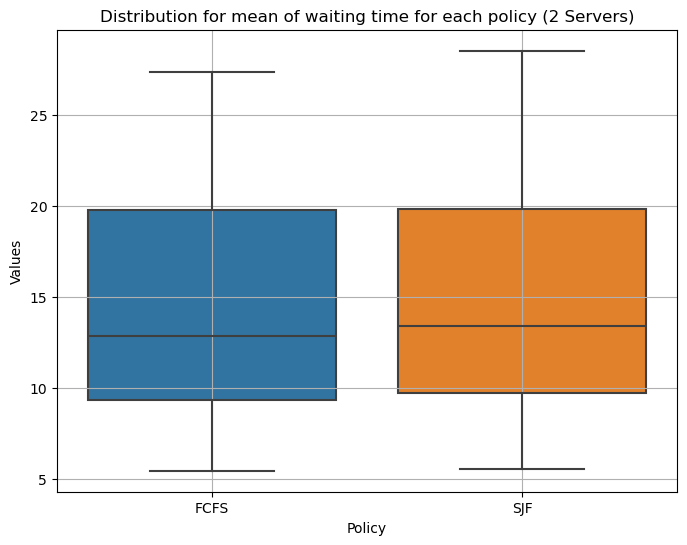

In [52]:
server_2_compare = pd.DataFrame({'FCFS': FCFS_2_data['Avg_Wait_Time'], 'SJF': SJF_2_data['Avg_Wait_Time']})
plt.figure(figsize=(8, 6))
sns.boxplot(data=server_2_compare)
plt.title('Distribution for mean of waiting time for each policy (2 Servers)')
plt.ylabel('Values')
plt.xlabel('Policy')
plt.grid(True)

plt.show()

In [36]:
server_5_compare = pd.DataFrame({'FCFS': FCFS_5_data['Avg_Wait_Time'], 'SJF': SJF_5_data['Avg_Wait_Time']})
plt.figure(figsize=(8, 6))
sns.boxplot(data=server_5_compare)
plt.title('Distribution for mean of waiting time for each policy (5 Servers)')
plt.ylabel('Values')
plt.xlabel('Policy')
plt.grid(True)

plt.show()

NameError: name 'FCFS_5_data' is not defined

In [4]:
server_10_compare = pd.DataFrame({'FCFS': FCFS_10_data['Avg_Wait_Time'], 'SJF': SJF_10_data['Avg_Wait_Time']})
plt.figure(figsize=(8, 6))
sns.boxplot(data=server_10_compare)
plt.title('Distribution for mean of waiting time for each policy (10 Servers)')
plt.ylabel('Values')
plt.xlabel('Policy')
plt.grid(True)

plt.show()

NameError: name 'pd' is not defined

#TODO Wrtie a compare policy, mostly 0 from 5,10 whereas 2 SJF seems a bit higher

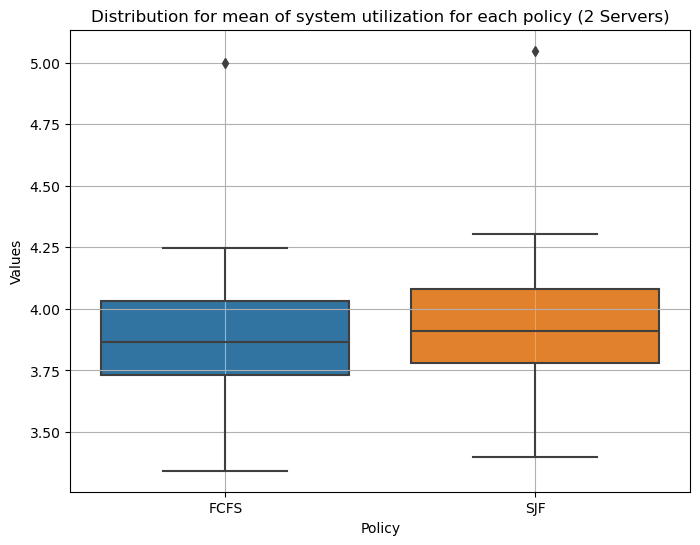

In [48]:
server_2_compare = pd.DataFrame({'FCFS': FCFS_2_data['System_Util'], 'SJF': SJF_2_data['System_Util']})
plt.figure(figsize=(8, 6))
sns.boxplot(data=server_2_compare)
plt.title('Distribution for mean of system utilization for each policy (2 Servers)')
plt.ylabel('Values')
plt.xlabel('Policy')
plt.grid(True)

plt.show()

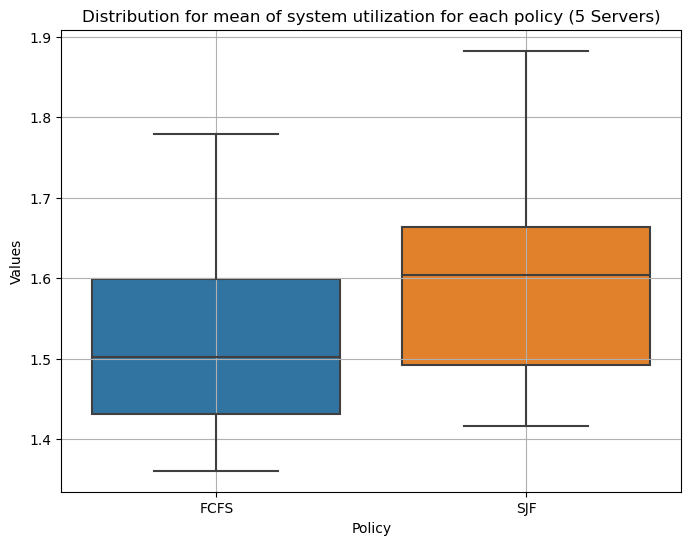

In [50]:
server_5_compare = pd.DataFrame({'FCFS': FCFS_5_data['System_Util'], 'SJF': SJF_5_data['System_Util']})
plt.figure(figsize=(8, 6))
sns.boxplot(data=server_5_compare)
plt.title('Distribution for mean of system utilization for each policy (5 Servers)')
plt.ylabel('Values')
plt.xlabel('Policy')
plt.grid(True)

plt.show()

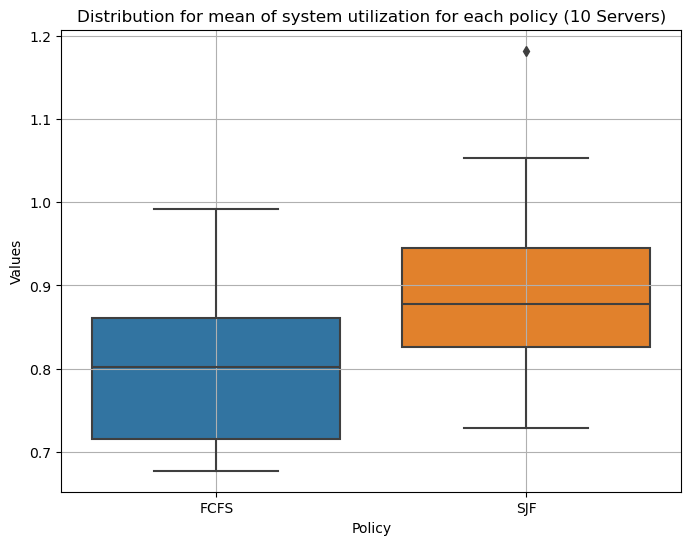

In [51]:
server_10_compare = pd.DataFrame({'FCFS': FCFS_10_data['System_Util'], 'SJF': SJF_10_data['System_Util']})
plt.figure(figsize=(8, 6))
sns.boxplot(data=server_10_compare)
plt.title('Distribution for mean of system utilization for each policy (10 Servers)')
plt.ylabel('Values')
plt.xlabel('Policy')
plt.grid(True)

plt.show()

### Section 4.2: Statistics Analysis

#### Section 4.2.1: Average Wait Time

In [ ]:
# Perform a t-test for 2 drive data

t_stat, p_value = stats.ttest_ind(FCFS_2_data['Avg_Wait_Time'], SJF_2_data['Avg_Wait_Time'])

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Calculate the mean difference between policies, its confidence interval, and prediction interval
mean_diff = np.mean(FCFS_2_data['Avg_Wait_Time']) - np.mean(SJF_2_data['Avg_Wait_Time'])
std_diff = np.sqrt(np.var(FCFS_2_data['Avg_Wait_Time'], ddof=1)/len(FCFS_2_data['Avg_Wait_Time']) + np.var(SJF_5_data['Avg_Wait_Time'], ddof=1)/len(SJF_5_data))
conf_interval = stats.t.interval(0.95, df=len(FCFS_2_data['Avg_Wait_Time'])+len(SJF_2_data['Avg_Wait_Time'])-2,
                                 loc=mean_diff, scale=std_diff)
pred_term = std_diff*np.sqrt(1+(1/number_request))
pred_interval = stats.t.interval(0.95, df=len(FCFS_2_data['Avg_Wait_Time'])+len(SJF_2_data['Avg_Wait_Time'])-2,
                                 loc=mean_diff, scale=pred_term)

print(f"Mean Difference: {mean_diff:.3f}")
print(f"95% Confidence Interval of the Difference: {conf_interval}")
print(f"95% Prediction Interval for the Difference: {pred_interval}")

# Calculate sample statistics and intervals for FCFS policy, 2 drives
mean_FCFS = np.mean(FCFS_2_data['Avg_Wait_Time'])
std_FCFS = np.std(FCFS_2_data['Avg_Wait_Time'], ddof=1)

number_request = 1000
df = number_request - 1

confidence = 0.95
t_critical = stats.t.ppf((1 + confidence) / 2, df)

margin_of_error_c = t_critical * (std_FCFS / np.sqrt(number_request))
conf_interval = (mean_FCFS - margin_of_error_c, mean_FCFS + margin_of_error_c)

margin_of_error_p = t_critical * std_FCFS * (np.sqrt(1 + (1 / number_request)))
pred_interval = (mean_FCFS - margin_of_error_p, mean_FCFS + margin_of_error_p)

print(f"2 Drives FCFS Average Wait Time: {mean_FCFS}")
print(f"2 Drives FCFS Standard Deviation: {std_FCFS}")
print(f"95% Confidence Interval for FCFS 2 Drives: {conf_interval}")
print(f"95% Prediction Interval for FCFS 2 Drives: {pred_interval}")

# Calculate sample statistics and intervals for SJF policy, 2 drives
mean_SJF = np.mean(SJF_2_data['Avg_Wait_Time'])
std_SJF = np.std(SJF_2_data['Avg_Wait_Time'], ddof=1)

number_request = 1000
df = number_request - 1

confidence = 0.95
t_critical = stats.t.ppf((1 + confidence) / 2, df)

margin_of_error_c = t_critical * (std_SJF / np.sqrt(number_request))
conf_interval = (mean_SJF - margin_of_error_c, mean_SJF + margin_of_error_c)

margin_of_error_p = t_critical * std_SJF * (np.sqrt(1 + (1 / number_request)))
pred_interval = (mean_SFJ - margin_of_error_p, mean_SJF + margin_of_error_p)

print(f"2 Drives SJF Average Wait Time: {mean_FCFS}")
print(f"2 Drives SJF Standard Deviation: {std_FCFS}")
print(f"95% Confidence Interval for SJF 2 Drives: {conf_interval}")
print(f"95% Prediction Interval for SJF 2 Drives: {pred_interval}")



NameError: name 'FCFS_2_data' is not defined

In [ ]:
# Perform a t-test for 5 drive data

t_stat, p_value = stats.ttest_ind(FCFS_5_data['Avg_Wait_Time'], SJF_5_data['Avg_Wait_Time'])

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Calculate the mean difference between policies, its confidence interval, and prediction interval
mean_diff = np.mean(FCFS_5_data['Avg_Wait_Time']) - np.mean(SJF_5_data['Avg_Wait_Time'])
std_diff = np.sqrt(np.var(FCFS_5_data['Avg_Wait_Time'], ddof=1)/len(FCFS_5_data['Avg_Wait_Time']) + np.var(SJF_5_data['Avg_Wait_Time'], ddof=1)/len(SJF_5_data))
conf_interval = stats.t.interval(0.95, df=len(FCFS_5_data['Avg_Wait_Time'])+len(SJF_5_data['Avg_Wait_Time'])-2,
                                 loc=mean_diff, scale=std_diff)
pred_term = std_diff*np.sqrt(1+(1/number_request))
pred_interval = stats.t.interval(0.95, df=len(FCFS_5_data['Avg_Wait_Time'])+len(SJF_5_data['Avg_Wait_Time'])-2,
                                 loc=mean_diff, scale=pred_term)

print(f"Mean Difference: {mean_diff:.3f}")
print(f"95% Confidence Interval of the Difference: {conf_interval}")
print(f"95% Prediction Interval for the Difference: {pred_interval}")


#  Calculate sample statistics and intervals for FCFS policy, 5 drives
mean_FCFS = np.mean(FCFS_5_data['Avg_Wait_Time'])
std_FCFS = np.std(FCFS_5_data['Avg_Wait_Time'], ddof=1)

number_request = 1000
df = number_request - 1

confidence = 0.95
t_critical = stats.t.ppf((1 + confidence) / 2, df)

margin_of_error_c = t_critical * (std_FCFS / np.sqrt(number_request))
conf_interval = (mean_FCFS - margin_of_error_c, mean_FCFS + margin_of_error_c)

margin_of_error_p = t_critical * std_FCFS * (np.sqrt(1 + (1 / number_request)))
pred_interval = (mean_FCFS - margin_of_error_p, mean_FCFS + margin_of_error_p)

print(f"5 Drives FCFS Average Wait Time: {mean_FCFS}")
print(f"5 Drives FCFS Standard Deviation: {std_FCFS}")
print(f"95% Confidence Interval for FCFS 5 Drives: {conf_interval}")
print(f"95% Prediction Interval for FCFS 5 Drives: {pred_interval}")

# Calculate sample statistics and intervals for SJF policy, 5 drives
mean_SJF = np.mean(SJF_5_data['Avg_Wait_Time'])
std_SJF = np.std(SJF_5_data['Avg_Wait_Time'], ddof=1)

number_request = 1000
df = number_request - 1

confidence = 0.95
t_critical = stats.t.ppf((1 + confidence) / 2, df)

margin_of_error_c = t_critical * (std_SJF / np.sqrt(number_request))
conf_interval = (mean_SJF - margin_of_error_c, mean_SJF + margin_of_error_c)

margin_of_error_p = t_critical * std_SJF * (np.sqrt(1 + (1 / number_request)))
pred_interval = (mean_SFJ - margin_of_error_p, mean_SJF + margin_of_error_p)

print(f"5 Drives SJF Average Wait Time: {mean_SJF}")
print(f"5 Drives SJF Standard Deviation: {std_SJF}")
print(f"95% Confidence Interval for SJF 5 Drives: {conf_interval}")
print(f"95% Prediction Interval for SJF 5 Drives: {pred_interval}")


NameError: name 'FCFS_5_data' is not defined

In [ ]:
# Perform a t-test for independent samples

t_stat, p_value = stats.ttest_ind(FCFS_10_data['Avg_Wait_Time'], SJF_10_data['Avg_Wait_Time'])

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Calculate the mean difference, its confidence interval, and prediction interval
mean_diff = np.mean(FCFS_10_data['Avg_Wait_Time']) - np.mean(SJF_10_data['Avg_Wait_Time'])
std_diff = np.sqrt(np.var(FCFS_10_data['Avg_Wait_Time'], ddof=1)/len(FCFS_10_data['Avg_Wait_Time']) + np.var(SJF_10_data['Avg_Wait_Time'], ddof=1)/len(SJF_10_data))
conf_interval = stats.t.interval(0.95, df=len(FCFS_10_data['Avg_Wait_Time'])+len(SJF_10_data['Avg_Wait_Time'])-2,
                                 loc=mean_diff, scale=std_diff)
pred_term = std_diff*np.sqrt(1+(1/number_request))
pred_interval = stats.t.interval(0.95, df=len(FCFS_10_data['Avg_Wait_Time'])+len(SJF_10_data['Avg_Wait_Time'])-2,
                                 loc=mean_diff, scale=pred_term)

print(f"Mean Difference: {mean_diff:.3f}")
print(f"95% Confidence Interval of the Difference: {conf_interval}")
print(f"95% Prediction Interval for the Difference: {pred_interval}")

#  Calculate sample statistics and intervals for FCFS policy, 10 drives
mean_FCFS = np.mean(FCFS_10_data['Avg_Wait_Time'])
std_FCFS = np.std(FCFS_10_data['Avg_Wait_Time'], ddof=1)

number_request = 1000
df = number_request - 1

confidence = 0.95
t_critical = stats.t.ppf((1 + confidence) / 2, df)

margin_of_error_c = t_critical * (std_FCFS / np.sqrt(number_request))
conf_interval = (mean_FCFS - margin_of_error_c, mean_FCFS + margin_of_error_c)

margin_of_error_p = t_critical * std_FCFS * (np.sqrt(1 + (1 / number_request)))
pred_interval = (mean_FCFS - margin_of_error_p, mean_FCFS + margin_of_error_p)

print(f"10 Drives FCFS Average Wait Time: {mean_FCFS}")
print(f"10 Drives FCFS Standard Deviation: {std_FCFS}")
print(f"95% Confidence Interval for FCFS 10 Drives: {conf_interval}")
print(f"95% Prediction Interval for FCFS 10 Drives: {pred_interval}")

# Calculate sample statistics and intervals for SJF policy, 10 drives
mean_SJF = np.mean(SJF_10_data['Avg_Wait_Time'])
std_SJF = np.std(SJF_10_data['Avg_Wait_Time'], ddof=1)

number_request = 1000
df = number_request - 1

confidence = 0.95
t_critical = stats.t.ppf((1 + confidence) / 2, df)

margin_of_error_c = t_critical * (std_SJF / np.sqrt(number_request))
conf_interval = (mean_SJF - margin_of_error_c, mean_SJF + margin_of_error_c)

margin_of_error_p = t_critical * std_SJF * (np.sqrt(1 + (1 / number_request)))
pred_interval = (mean_SFJ - margin_of_error_p, mean_SJF + margin_of_error_p)

print(f"10 Drives SJF Average Wait Time: {mean_SJF}")
print(f"10 Drives SJF Standard Deviation: {std_SJF}")
print(f"95% Confidence Interval for SJF 10 Drives: {conf_interval}")
print(f"95% Prediction Interval for SJF 10 Drives: {pred_interval}")


T-statistic: nan
P-value: nan
Mean Difference: 0.000
95% Confidence Interval of the Difference: (nan, nan)
Standard Error of the Mean of wait time for FCFS: 0.000
Standard Error of the Mean of wait time for SJF: 0.000


#### Section 4.2.2: System Utilization

In [ ]:
# Perform a t-test for independent samples

t_stat, p_value = stats.ttest_ind(FCFS_2_data['System_Util'], SJF_2_data['System_Util'])

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Calculate the mean difference, its confidence interval, and prediction interval
mean_diff = np.mean(FCFS_2_data['System_Util']) - np.mean(SJF_2_data['System_Util'])
std_diff = np.sqrt(np.var(FCFS_2_data['System_Util'], ddof=1)/len(FCFS_2_data['System_Util']) + np.var(SJF_2_data['System_Util'], ddof=1)/len(SJF_2_data))
conf_interval = stats.t.interval(0.95, df=len(FCFS_2_data['System_Util'])+len(SJF_2_data['System_Util'])-2,
                                 loc=mean_diff, scale=std_diff)
pred_term = std_diff*np.sqrt(1+(1/number_request))
pred_interval = stats.t.interval(0.95, df=len(FCFS_2_data['System_Util'])+len(SJF_2_data['System_Util'])-2,
                                 loc=mean_diff, scale=pred_term)

print(f"Mean Difference: {mean_diff:.3f}")
print(f"95% Confidence Interval of the Difference: {conf_interval}")
print(f"95% Prediction Interval of the Difference: {pred_interval}")


T-statistic: -0.814
P-value: 0.419
Mean Difference: -0.063
95% Confidence Interval of the Difference: (-0.2180860193159556, 0.09201823087974778)
Standard Error of the Mean of system utilization for FCFS: 0.054
Standard Error of the Mean of system utilization for SJF: 0.055


In [ ]:
# Perform a t-test for independent samples

t_stat, p_value = stats.ttest_ind(FCFS_5_data['System_Util'], SJF_5_data['System_Util'])

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Calculate the mean difference and its confidence interval
mean_diff = np.mean(FCFS_5_data['System_Util']) - np.mean(SJF_5_data['System_Util'])
std_diff = np.sqrt(np.var(FCFS_5_data['System_Util'], ddof=1)/len(FCFS_5_data['System_Util']) + np.var(SJF_5_data['System_Util'], ddof=1)/len(SJF_5_data))
conf_interval = stats.t.interval(0.95, df=len(FCFS_5_data['System_Util'])+len(SJF_5_data['System_Util'])-2,
                                 loc=mean_diff, scale=std_diff)
pred_term = std_diff*np.sqrt(1+(1/number_request))
pred_interval = stats.t.interval(0.95, df=len(FCFS_5_data['System_Util'])+len(SJF_5_data['System_Util'])-2,
                                 loc=mean_diff, scale=pred_term)

print(f"Mean Difference: {mean_diff:.3f}")
print(f"95% Confidence Interval of the Difference: {conf_interval}")
print(f"95% Prediction Interval of the Difference: {pred_interval}")


T-statistic: -2.586
P-value: 0.012
Mean Difference: -0.081
95% Confidence Interval of the Difference: (-0.14424517727547104, -0.01837485153231444)
Standard Error of the Mean of system utilization for FCFS: 0.021
Standard Error of the Mean of system utilization for SJF: 0.023


In [ ]:
# Perform a t-test for independent samples

t_stat, p_value = stats.ttest_ind(FCFS_10_data['System_Util'], SJF_10_data['System_Util'])

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Calculate the mean difference and its confidence interval
mean_diff = np.mean(FCFS_10_data['System_Util']) - np.mean(SJF_10_data['System_Util'])
std_diff = np.sqrt(np.var(FCFS_10_data['System_Util'], ddof=1)/len(FCFS_10_data['System_Util']) + np.var(SJF_10_data['System_Util'], ddof=1)/len(SJF_10_data))
conf_interval = stats.t.interval(0.95, df=len(FCFS_10_data['System_Util'])+len(SJF_10_data['System_Util'])-2,
                                 loc=mean_diff, scale=std_diff)
pred_term = std_diff*np.sqrt(1+(1/number_request))
pred_interval = stats.t.interval(0.95, df=len(FCFS_10_data['System_Util'])+len(SJF_10_data['System_Util'])-2,
                                 loc=mean_diff, scale=pred_term)

print(f"Mean Difference: {mean_diff:.3f}")
print(f"95% Confidence Interval of the Difference: {conf_interval}")
print(f"95% Prediction Interval pf the Difference: {pred_interval}")


T-statistic: -3.768
P-value: 0.000
Mean Difference: -0.092
95% Confidence Interval of the Difference: (-0.14163847258061574, -0.04335899248187953)
Standard Error of the Mean of system utilization for FCFS: 0.016
Standard Error of the Mean of system utilization for SJF: 0.019
